# Graph features

## Import dependencies

In [1]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from gedcom5.parser import GEDCOM5Parser
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Extract data

### Parse GEDCOM file

In [2]:
parser = GEDCOM5Parser()

with open("data/royal92.ged") as f:
    gedcom = parser.parse_string(f.read())

### Graph linking individuals and families

In [3]:
G = nx.Graph()

G.add_edges_from(
    (indi.xref_id, fam.value)
    for indi in gedcom.indi
    for fam in itertools.chain(indi.famc, indi.fams)
)

G.number_of_nodes(), G.number_of_edges()

(4429, 4578)

In [4]:
# G = G.subgraph(max(nx.connected_components(G), key=len))

G.number_of_nodes(), G.number_of_edges()

(4429, 4578)

### Affinity matrix

In [5]:
H = nx.convert_node_labels_to_integers(G, ordering="sorted")

In [6]:
H.number_of_nodes()

4429

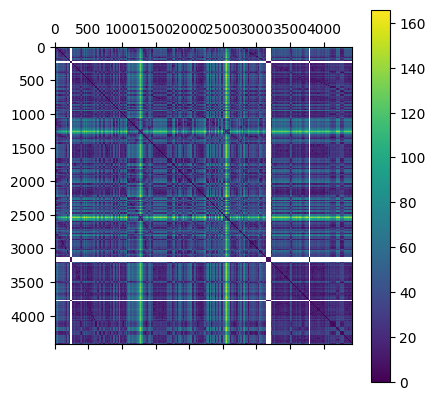

In [7]:
shape = (
    H.number_of_nodes(),
    H.number_of_nodes(),
)

distance = np.full(shape, np.nan)
for i, jd in nx.all_pairs_shortest_path_length(H):
    for j, d in jd.items():
        distance[i, j] = d

plt.matshow(distance)
plt.colorbar();

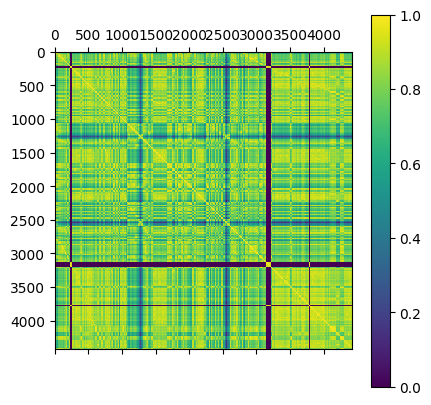

In [8]:
affinity = np.nan_to_num(1.0 - distance / np.nanmax(distance))

plt.matshow(affinity)
plt.colorbar();

## Order reduction

In [9]:
pca = PCA(whiten=True, svd_solver="full")
pca.fit(affinity)

PCA(svd_solver='full', whiten=True)

In [10]:
threshold = 0.99
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

n_components = np.searchsorted(cumulative_ratio, threshold) + 1
n_components

4

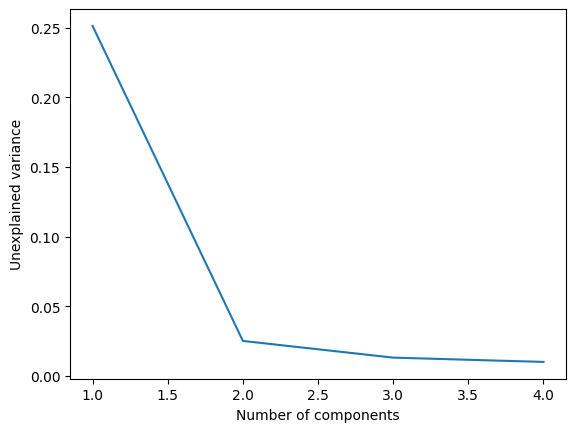

In [11]:
x = np.arange(n_components) + 1
y = 1.0 - cumulative_ratio[:n_components]

fig, ax = plt.subplots()
ax.set_xlabel("Number of components")
ax.set_ylabel("Unexplained variance")
plt.plot(x, y);

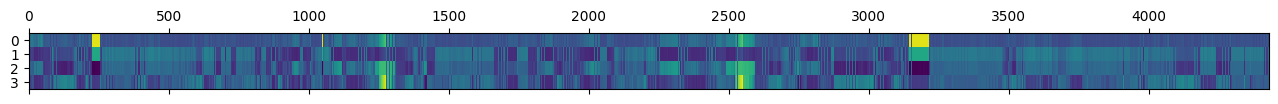

In [12]:
pca = PCA(
    n_components=n_components,
    whiten=True,
    svd_solver="arpack",
)
features = pca.fit_transform(affinity)

plt.matshow(features.T, aspect=50);

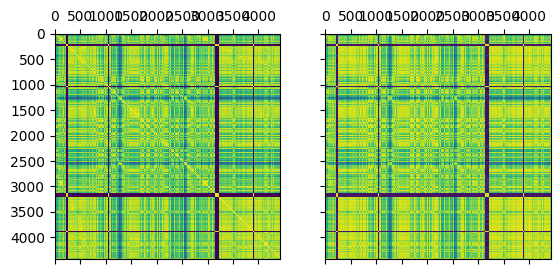

In [13]:
roundtrip = pca.inverse_transform(features)

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].matshow(affinity)
ax[1].matshow(roundtrip);

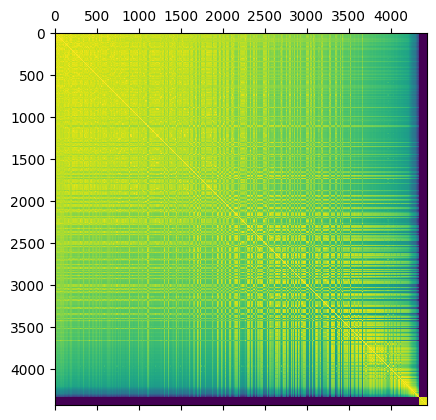

In [14]:
plt.matshow(
    affinity[
        np.ix_(
            features[:, 0].argsort(),
            features[:, 0].argsort(),
        )
    ]
);

## Clustering

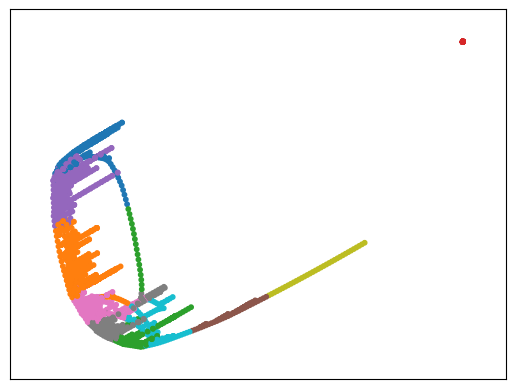

In [15]:
pipeline = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=10, n_init="auto", random_state=0),
)

labels = pipeline.fit_predict(features)

x = features[:, 0]
y = features[:, 1]

pos = dict(enumerate(zip(x, y)))
color = labels / np.max(labels)

fig, ax = plt.subplots()
nx.draw_networkx_edges(H, pos, ax=ax)
ax.scatter(x, y, s=10.0, c=color, cmap="tab10");

## Export features

In [16]:
df = pd.DataFrame(data=features, index=G.nodes)
df.to_csv("data/graph_features.csv")
df

,0,1,2,3
@I1@,0.577792,-0.360320,1.154970,-1.928660
@F42@,0.603071,-0.497670,0.963891,-1.813704
@F1@,0.624987,-0.633886,0.765493,-1.663857
@I2@,0.638989,-0.765938,0.561206,-1.449884
@F43@,0.635261,-0.885267,0.365468,-1.141019
...,...,...,...,...
@I3006@,-0.272970,-1.003930,-1.210368,0.002895
@I3007@,-0.330811,-0.918126,-1.364303,0.332938
@I3008@,-0.329129,-0.912464,-1.351566,0.359515
@I3009@,-0.599596,0.720528,0.369262,0.088158
